In [256]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [257]:
config = load_config("../config.yaml")
taskset = "PDM"

In [258]:
def parse_model_info(model_name):
    model_name = model_name.replace('.pth', '')
    model_name = model_name.split('_')
    model_type = model_name[0] + '_' + model_name[1]
    if len(model_name) == 8:    
        activation = model_name[2] + '_' + model_name[3]
        hidden_size = int(model_name[4])
        learning_rate = float(model_name[5])
        batch_size = int(model_name[6])
    else:
        activation = model_name[2]
        hidden_size = int(model_name[3])
        learning_rate = float(model_name[4])
        batch_size = int(model_name[5])
    return model_type, activation, hidden_size, learning_rate, batch_size

parse_model_info('leaky_gru_leaky_relu_128_0.001_128_train.pth')



('leaky_gru', 'leaky_relu', 128, 0.001, 128)

In [259]:
def get_dynamics_rnn(rnn_type, activation, hidden_size, lr, model, group,device, n_components=3):
    # Load configuration and set hyperparameters
    config = load_config("../config.yaml")
    ruleset = config[taskset]["rules_analysis"][-1]
    all_rules = config[taskset]["rules_analysis"]

    hp = {
        "rnn_type": rnn_type,
        "activation": activation,
        "n_rnn": hidden_size,
        "learning_rate": lr,
        "l2_h": 0.00001,
        "l2_weight": 0.00001,
        "mode": "test",
    }
    hp, _, _ = main.set_hyperparameters(
        model_dir="debug", hp=hp, ruleset=all_rules, rule_trains=ruleset
    )
    run_model = main.load_model(
        f"../models/{taskset}/{group}/{model}",
        hp,
        RNNLayer,
        device=device,
    )
    h = main.representation(run_model, all_rules)
    return h

### Get dynamics to plot

In [301]:
model = "leaky_rnn_softplus_128_0.001_64_train.pth"

#### Pretrain unfrozen

In [302]:
group = "master"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_master = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [303]:
group = "pretrain_unfrozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_pretrain_unfrozen = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [304]:
group = "pretrain_frozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_pretrain_frozen= get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [305]:
group = "untrained"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_untrained = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [306]:
group = "anti"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_anti = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3
)

In [307]:
group = "delay"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_delay = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3
)

In [308]:
group = "pretrained_basic_anti_frozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_pretrained_basic_anti_frozen = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [309]:
group = "pretrained_basic_anti_unfrozen"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_pretrained_basic_anti_unfrozen = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [310]:
group = "basic"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve_basic = get_dynamics_rnn(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=20
)

In [311]:
curves = [curve_untrained, curve_basic, curve_anti, curve_delay, curve_master, curve_pretrained_basic_anti_frozen, curve_pretrain_frozen, curve_pretrain_unfrozen]
curves_reduced, explained_variance = main.compute_common_pca(curves, n_components=100)
curves = curves_reduced
# normalize all the curves
# for i in range(len(curves)):
#     curves[i] = (curves[i] - np.mean(curves[i])) / np.std(curves[i])

In [312]:
explained_variance

1.0000658657077306

#### Visualize the curves

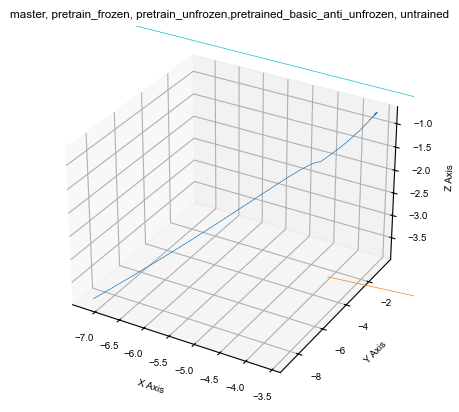

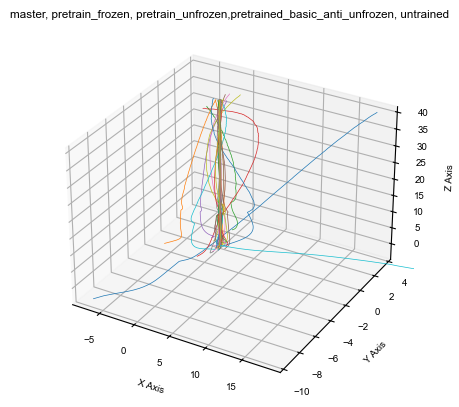

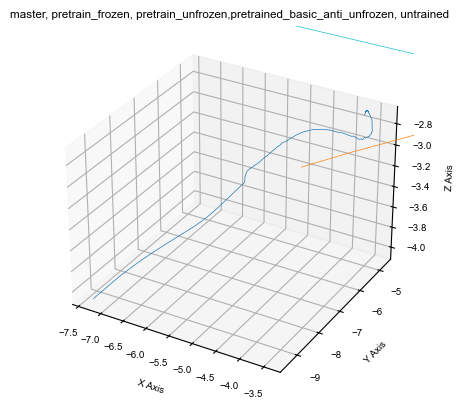

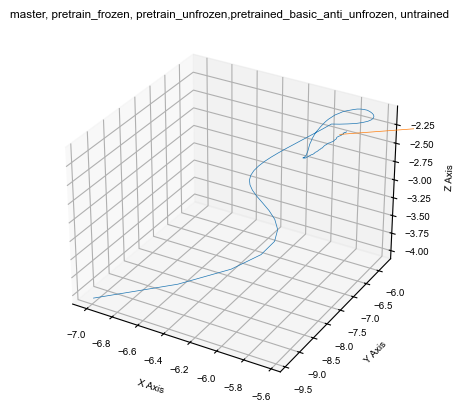

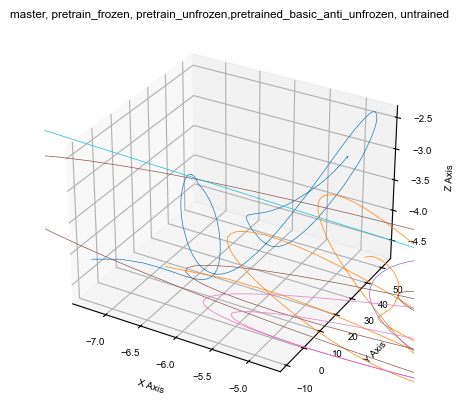

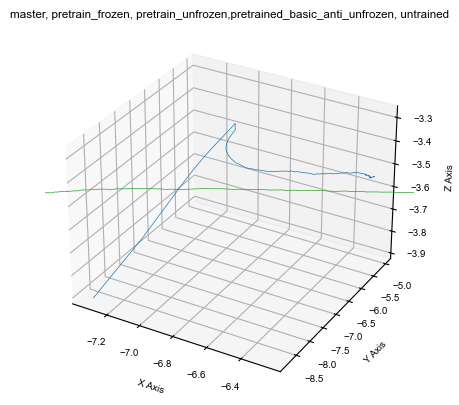

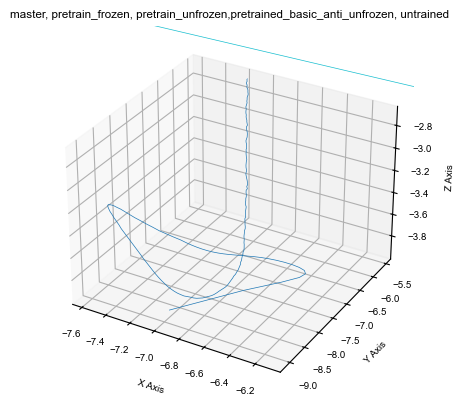

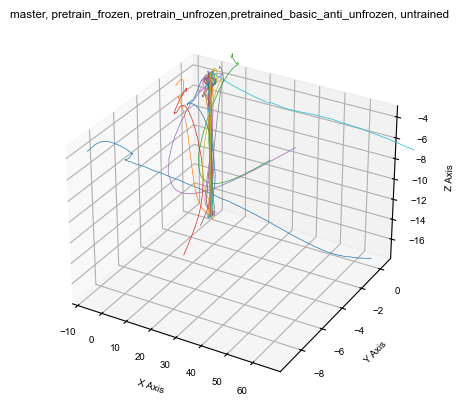

In [313]:
visualize(curves,title="master, pretrain_frozen, pretrain_unfrozen,pretrained_basic_anti_unfrozen, untrained")
# visualize(
#     [
#         curve_master[:, 0, :],
#         curve_anti[:, 100, :],
#         curve_pretrain_frozen[:, 100, :],
#         curve_pretrain_unfrozen[:, 100, :],
#         curve_untrained[:, 100, :],
#     ],
#     title="master, pretrain_frozen, pretrain_unfrozen, untrained",
# )

In [320]:
# compute DSA dissimilarity matrix
dsa_comp = DSA.DSA(
                curves,
                # n_delays=config["dsa"]["n_delays"],
                n_delays=50,
                rank=20,
                # delay_interval=config["dsa"]["delay_interval"],
                delay_interval=1,
                verbose=True,
                iters=1000,
                lr=1e-2,
                device="cpu",
            )
dissimilarities = dsa_comp.fit_score()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HA

In [321]:
curves[0].shape

(200, 100)

<Axes: >

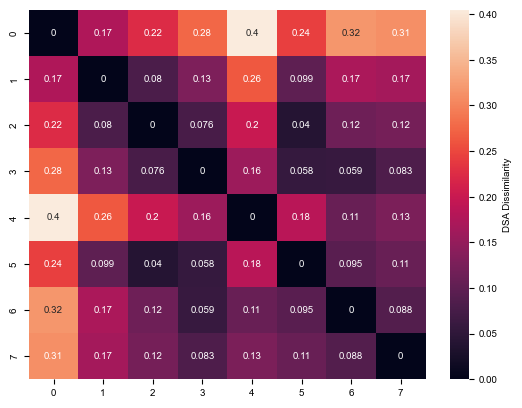

In [322]:
# plot DSA dissimilarity matrix with heatmap and annotations as strings of curves
sns.heatmap(dissimilarities, annot=True, cbar_kws={"label": "DSA Dissimilarity"})

### Get dissimilarities

#### Computation dynamics

In [ ]:
groups = [
    "untrained",
    "basic",
    "anti",
    "delay",
    "master",
    "pretrained_basic_anti_frozen",
    "pretrain_frozen",
    "pretrained_basic_anti_unfrozen",
    "pretrain_unfrozen",
]

In [ ]:
path = f"../data/dissimilarities/{taskset}/"
measures = ["cka", "dsa", "procrustes"]
dissimilarities = {measure: [] for measure in measures}


for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if file_path.endswith(".npz"):
            print(file_path)
            with np.load(file_path, allow_pickle=True) as data:
                dissimilarities[measure].append(data["arr_0"])

../data/dissimilarities/PDM/cka/leaky_gru_relu_128_0.001_128_train.npz
../data/dissimilarities/PDM/dsa/leaky_gru_relu_128_0.001_128_train.npz
../data/dissimilarities/PDM/procrustes/leaky_gru_relu_128_0.001_128_train.npz


In [ ]:
with np.load(os.path.join(path,"dsa/leaky_gru_relu_128_0.001_128_train.npz"), allow_pickle=True) as data:
    dis_spec = data["arr_0"]

In [ ]:
for i in range(dis_spec.shape[0]):
    for j in range(i, dis_spec.shape[1]):
        dis_spec[j, i] = dis_spec[i, j]

In [ ]:
dis_spec

array([[0.        , 0.29914701, 0.39206788, 0.39401662, 0.44526899,
        0.37146327, 0.35397342, 0.3036297 , 0.36213133],
       [0.29914701, 0.        , 0.11096396, 0.1245328 , 0.1728621 ,
        0.10555617, 0.07402655, 0.05034804, 0.09279645],
       [0.39206788, 0.11096396, 0.        , 0.0495578 , 0.07568196,
        0.05922068, 0.06095762, 0.10762241, 0.05123792],
       [0.39401662, 0.1245328 , 0.0495578 , 0.        , 0.07166968,
        0.06739822, 0.0666426 , 0.11552753, 0.0677698 ],
       [0.44526899, 0.1728621 , 0.07568196, 0.07166968, 0.        ,
        0.10001063, 0.11593376, 0.1711085 , 0.10663684],
       [0.37146327, 0.10555617, 0.05922068, 0.06739822, 0.10001063,
        0.        , 0.05600128, 0.09925138, 0.06967936],
       [0.35397342, 0.07402655, 0.06095762, 0.0666426 , 0.11593376,
        0.05600128, 0.        , 0.07310042, 0.06042894],
       [0.3036297 , 0.05034804, 0.10762241, 0.11552753, 0.1711085 ,
        0.09925138, 0.07310042, 0.        , 0.0868446 ],


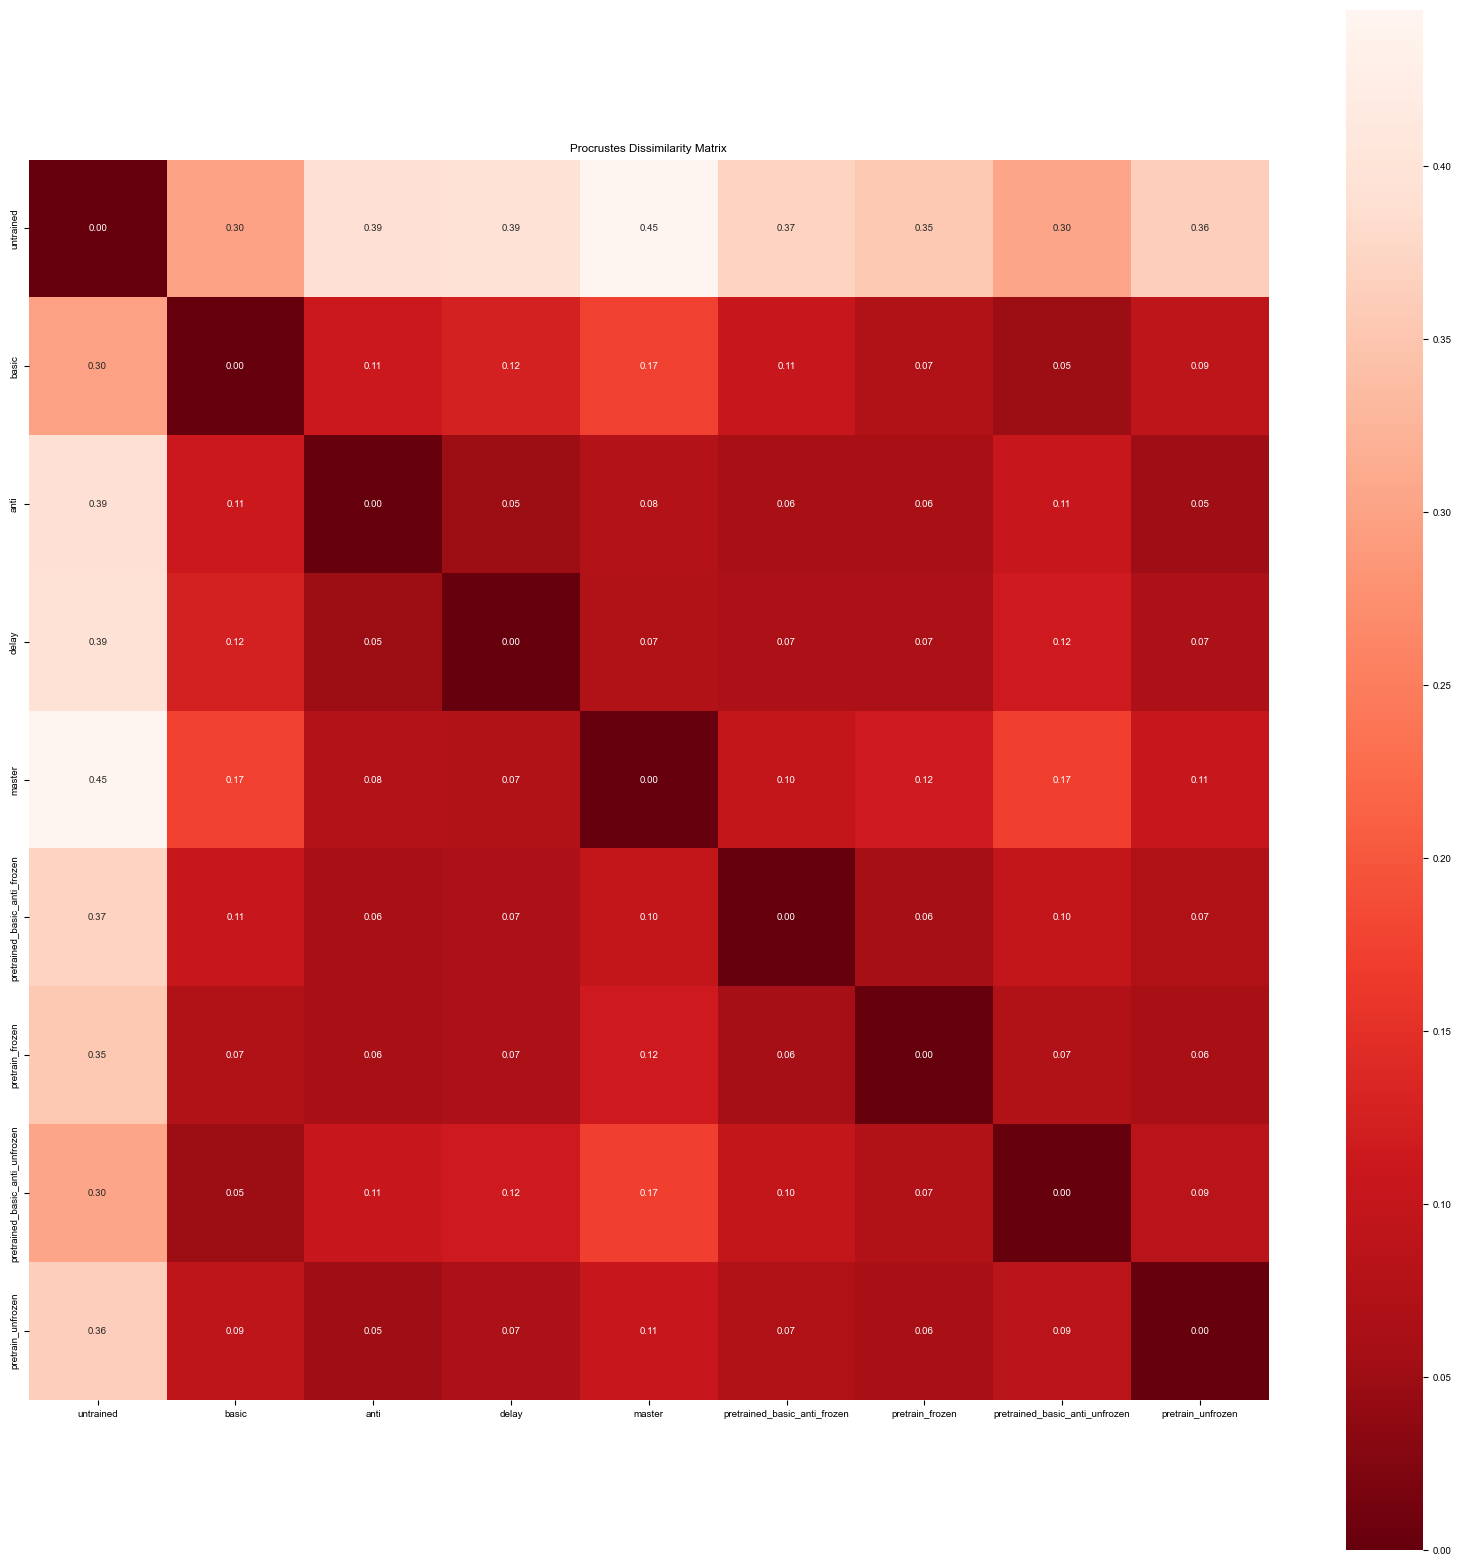

In [ ]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(
    dis_spec, annot=True, cmap="Reds_r", cbar=True, square=True, fmt=".2f"
)

# Set the percentage labels on the x and y axes
ax.set_xticklabels(groups)
ax.set_yticklabels(groups)

# Set the title
plt.title(f"{measure.capitalize()} Dissimilarity Matrix")

# Show the plot
plt.show()

In [ ]:
dissimilarities["dsa"] = [arr for arr in dissimilarities["dsa"] if arr.shape != ()]
dissimilarities["cka"] = [arr for arr in dissimilarities["dsa"] if arr.shape != ()]
dissimilarities[""] = [arr for arr in dissimilarities["dsa"] if arr.shape != ()]

In [ ]:
dissimilarities["dsa"]= np.nanmean(dissimilarities["dsa"], axis=0)

In [ ]:
dis = copy.deepcopy(dissimilarities["dsa"])
for i in range(dis.shape[0]):
    for j in range(i, dis.shape[1]):
        dis[j, i] = dis[i, j]
dissimilarities["dsa"] = dis

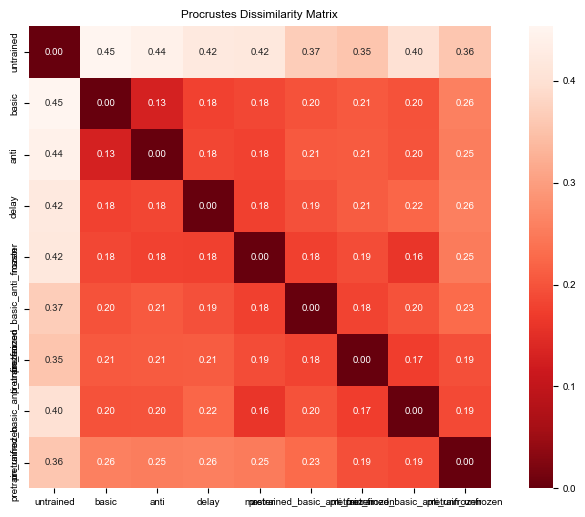

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(dissimilarities["dsa"], annot=True, cmap="Reds_r", cbar=True, square=True, fmt=".2f")

# Set the percentage labels on the x and y axes
ax.set_xticklabels(groups)
ax.set_yticklabels(groups)

# Set the title
plt.title(f"{measure.capitalize()} Dissimilarity Matrix")

# Show the plot
plt.show()

In [ ]:
groups = [
    "pretrain_frozen",
    "pretrain_unfrozen",
    "pretrained_basic_anti_frozen",
    "pretrained_basic_anti_unfrozen",
    "master",
    "untrained",
    "basic",
    "anti",
]
for measure, value in dissimilarities.items():
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(value, annot=True, cmap="Reds", cbar=True, square=True, fmt=".2f")

    # Set the percentage labels on the x and y axes
    ax.set_xticklabels(groups)
    ax.set_yticklabels(groups)

    # Set axis labels
    ax.set_xlabel("Groups")
    ax.set_ylabel("Groups")

    # Set the title
    plt.title(f"{measure.capitalize()} Dissimilarity Matrix")

    # Show the plot
    plt.show()

In [ ]:
# unique groups :
from asyncio import tasks


groups = list(config[taskset]["groups"].keys())
# generate all possible pairs of groups
pairs = [
    (groups[i], groups[j]) for i in range(len(groups)) for j in range(i, len(groups))
]
# group pairs of groups by how many tasks they share in their training curriculum
group_pairs = {}
for pair in pairs:
    group1, group2 = pair
    group1_tasks = (
        config[taskset]["groups"][group1]["pretrain"]["ruleset"]
        + config[taskset]["groups"][group1]["train"]["ruleset"]
        if config[taskset]["groups"][group1]["train"]["frozen"] == False
        else config[taskset]["groups"][group1]["pretrain"]["ruleset"]
    )
    group2_tasks = (
        config[taskset]["groups"][group2]["pretrain"]["ruleset"]
        + config[taskset]["groups"][group2]["train"]["ruleset"]
        if config[taskset]["groups"][group2]["train"]["frozen"] == False
        else config[taskset]["groups"][group2]["pretrain"]["ruleset"]
    )
    if len(group1_tasks) == 0 and len(group2_tasks) == 0:
        shared_tasks = 100
    elif len(group1_tasks) == 0 or len(group2_tasks) == 0:
        shared_tasks = 0
    else:
        shared_tasks = int(
            100
            * len(set(group1_tasks).intersection(set(group2_tasks)))
            / max(len(group1_tasks), len(group2_tasks))
        )
    try:
        group_pairs[shared_tasks].append(pair)
    except KeyError:
        group_pairs[shared_tasks] = [pair]

In [ ]:
dissimilarities_per_shared_task_cka = {}
dissimilarities_per_shared_task_procrustes = {}
dissimilarities_per_shared_task_dsa = {}
for shared_tasks, pairs in group_pairs.items():
    for pair in pairs:
        group1, group2 = pair

        data_pair = data[
            ((data["group1"] == group1) & (data["group2"] == group2))
            # or the opposite
            |
            ((data["group1"] == group2) & (data["group2"] == group1))
        ]
        try:
            dissimilarities_per_shared_task_cka[shared_tasks].append(data_pair["cka"].values)
            dissimilarities_per_shared_task_procrustes[shared_tasks].append(data_pair["procrustes"].values)
            dissimilarities_per_shared_task_dsa[shared_tasks].append(data_pair["dsa_mean"].values)
        except KeyError:
            dissimilarities_per_shared_task_cka[shared_tasks] = [data_pair["cka"].values]
            dissimilarities_per_shared_task_procrustes[shared_tasks] = [data_pair["procrustes"].values]
            dissimilarities_per_shared_task_dsa[shared_tasks] = [data_pair["dsa"].values]

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


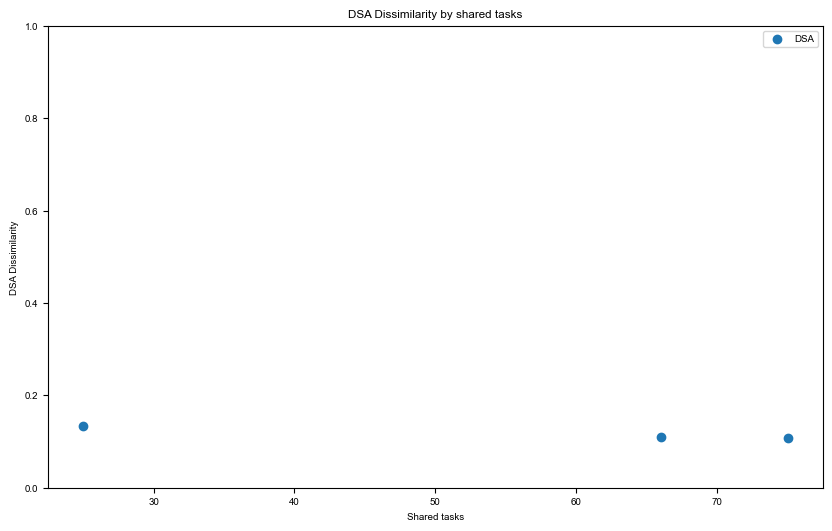

In [ ]:
# plot the dissimilarities per shared task by taking median of the dissimilarities for each shared task. shared task as x-axis and dissimilarity as y-axis and do a line plot without errors
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(dissimilarities_per_shared_task_dsa.keys(), [np.mean(d) for d in dissimilarities_per_shared_task_dsa.values()], label="DSA")
plt.xlabel("Shared tasks")
plt.ylim(0, 1)
plt.ylabel("DSA Dissimilarity")
plt.title("DSA Dissimilarity by shared tasks")
plt.legend()







#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [ ]:
# take all the folder names under data/dissimilarities_over_learning/{taskset}
groups_training = os.listdir(f"../data/dissimilarities_over_learning/{taskset}")

dissimilarities_groups = {group: None for group in groups_training}
for group_training in groups_training: 
    path = f"../data/dissimilarities_over_learning/{taskset}/{group_training}"
    measures = ["cka", "dsa", "procrustes", "accuracy_1", "accuracy_2"]
    sampling = [0, 25, 50, 75, 100]
    dissimilarities = {measure: [] for measure in measures}

    for measure in measures:
        path_measure = os.path.join(path, measure)
        files = os.listdir(path_measure)
        for file in files:
            file_path = os.path.join(path_measure, file)
            if file_path.endswith(".npz"):
                with np.load(file_path) as data:
                    dissimilarities[measure].append(data["arr_0"])
    dissimilarities_interpolated = {
        measure: {group: [] for group in range(len(sampling) - 1)} for measure in measures
    }
    for measure in measures:
        for dissimilarity in dissimilarities[measure]:
            if dissimilarity.shape[0] > 4:
                for i in range(len(sampling) - 1):
                    index_start = int(sampling[i] / 100 * (dissimilarity.shape[0]))
                    index_end = int(sampling[i + 1] / 100 * (dissimilarity.shape[0]))
                    dissimilarities_interpolated[measure][i].append(
                        np.median(dissimilarity[index_start:index_end])
                    )
    for measure in measures:
        for group in range(len(sampling) - 1):
            dissimilarities_interpolated[measure][group] = np.mean(
                dissimilarities_interpolated[measure][group]
            )
    dissimilarities_groups[group_training] = dissimilarities_interpolated

In [ ]:
for group_training in groups_training:
    dissimilarities_interpolated = dissimilarities_groups[group_training]
    # X-axis values
    x_values = [25, 50, 75, 100]

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot each key with a different color
    for key, values in dissimilarities_interpolated.items():
        plt.plot(x_values, list(values.values()), marker="o", label=key)

    # Adding labels and title
    plt.xlabel("Percentage of Training")
    plt.ylabel("Values")
    plt.title("Dissimilarity over training for {}".format(group_training))
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

### Dissimilarity within group 

In [ ]:
path = f"../data/dissimilarities_within_learning/{taskset}/pretrain_frozen"
measures = ['cka','dsa','procrustes']
dissimilarities = {measure:[] for measure in measures}


for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if file_path.endswith(".npz"):
            with np.load(file_path) as data:
                dissimilarities[measure].append(data["arr_0"])
# Function to check if any non-diagonal element is less than the threshold
def has_small_non_diagonal_elements(arr, threshold=1e-10):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i != j and arr[i, j] < threshold:
                return True
    return False
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = [
        arr for arr in value if not has_small_non_diagonal_elements(arr)
    ]
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = np.median(np.stack(value, axis=0), axis=0)

In [ ]:
# Percentage labels to use instead of indices
percent_labels = ["25%", "50%", "75%", "100%"]

for measure, value in dissimilarities.items():
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(value, annot=True, cmap="Reds", cbar=True, square=True, fmt=".2f")

    # Set the percentage labels on the x and y axes
    ax.set_xticklabels(percent_labels)
    ax.set_yticklabels(percent_labels)

    # Set axis labels
    ax.set_xlabel("Training Progress")
    ax.set_ylabel("Training Progress")

    # Set the title
    plt.title(f"{measure.capitalize()} Dissimilarity Over Training")

    # Show the plot
    plt.show()